# Predicting the political bias of news articles with linear models

This notebook tests classifiers over a [Webhose.io](https://webhose.io/) crawl of 30k+ news articles. The crawl covers 10 major media sources over a one month period, in June 2018. The articles range widely in their content (entertainment, politics, sports, etc).

## Load Preprocessed Webhose Data

In [90]:
#import pandas
import pandas as pd 

# define csv read
def read_data2(filename):
    # read in csv
    df = pd.read_csv(filename, sep='\t', encoding='utf-8')
    
    #drop first column (index)
    df = df.drop(df.columns[0], axis=1)
    
    return df

# load cleaned file with sentiment data
new = read_data2('webhose-corpus-df-clean.csv')
new.head()

,bias,source,headline,text,date,sentences,reading,length
0,3,Washington Times,group sues county permit oil refinery near park,print thursday june bismarck ap dakota resourc...,2018-06-15,10,13.2,145
1,3,Breitbart,man claims asked leave restaurant wearing larg...,man claims asked leave restaurant wearing larg...,2018-06-10,17,10.8,360
2,1,New York Times,able handle hbo,media analysts tech industry prognosticators l...,2018-06-14,73,10.2,1231
3,1,New York Times,summer skiing getaways southern hemisphere,summer popular time beach vacations sun water ...,2018-06-05,27,11.1,513
4,1,New York Times,fact check corey stewart republicans fringe right,fact check corey stewart republicans fringe ri...,2018-06-14,80,11.5,1173


In [ ]:
## load All Sides test corpus
test_corpus = read_data2('news-corpus-df-clean.csv')

### Remove Short Texts

In [92]:
import seaborn as sns

(0, 3000)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


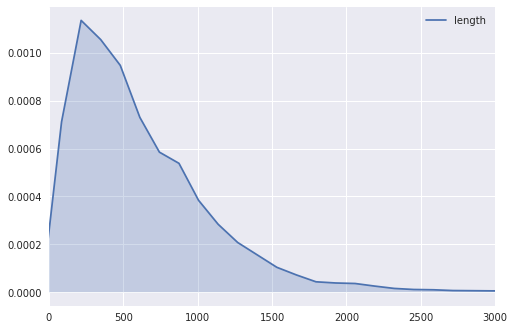

In [93]:
# get density plot of text length
lengthplot = sns.kdeplot(new.length, shade=True);
axes = lengthplot.axes 
axes.set_xlim(0,3000)

In [94]:
# examine distribution of text lengths
from scipy import stats
print(stats.describe(new.length))

DescribeResult(nobs=31184, minmax=(1, 16347), mean=611.6549833247819, variance=378989.9508374945, skewness=6.3243737752776585, kurtosis=98.82363857350938)


In [95]:
# how many texts in the dataset under/over a certain length?
print('Under 100 words: ', len(new[new.length < 100]))
print('Over 2500 words: ', len(new[new.length > 2000]))

Under 100 words:  2179
Over 2500 words:  680


In [96]:
# clip dataset of overly short / lengthy texts
new = new[new.length > 100]
new = new[new.length < 2000]

### Assess Readability Across Bias Groups

(0, 30)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


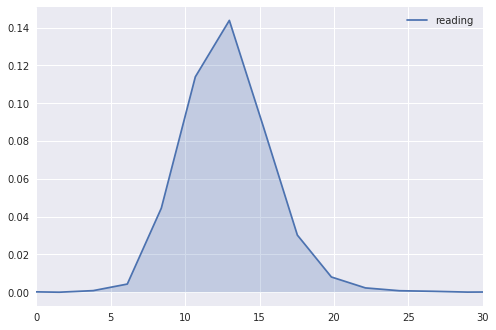

In [97]:
import seaborn as sns
readplot = sns.kdeplot(new.reading, shade=True);
axes = readplot.axes 
axes.set_xlim(0,30)

In [98]:
#new.groupby('bias')['reading'].mean()
new['reading'].groupby(new['bias']).describe()

,count,mean,std,min,25%,50%,75%,max
bias,,,,,,,,
1,9406.0,12.666532,3.468662,0.4,10.7,12.5,14.3,132.6
2,9389.0,12.960006,5.548951,2.2,10.5,12.7,14.9,288.4
3,9502.0,13.007788,2.762224,1.5,11.2,12.8,14.5,49.2


In [99]:
#new['reading'].groupby(new['bias']).plot.kde();

### Equalize Bias Groups

**Note**: Decided not to implement.

In [100]:
# check num of center labeled stories
print('Left: ', new.loc[new['bias'] == 1].shape[0])
print('Center: ', new.loc[new['bias'] == 2].shape[0])
print('Right: ', new.loc[new['bias'] == 3].shape[0])

Left:  9406
Center:  9389
Right:  9502


### Define Features

In [101]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier

In [102]:
# get text function
def get_text(X):
  return X['text'].values

# get source function
def get_source(X):
  return X['source'].values

# get bias function
def get_bias(y):
  return y['bias'].values

### Create a Pipeline Incorporating Multiple Features

In [103]:
from sklearn.svm import LinearSVC

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('get_text', FunctionTransformer(get_text, validate=False)),
            ('tfidf', TfidfVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.4, min_df = 0.05, sublinear_tf=True, norm='l2' )), 
        ])),
        ('source', Pipeline([
            ('get_text', FunctionTransformer(get_source, validate=False)),
            ('tfidf2', TfidfVectorizer(ngram_range=(1,5), sublinear_tf=True, norm='l2' )), 
        ])),
      ],
        # weight components in FeatureUnion
        transformer_weights={
            'text': 1,
            'source': 1.5,
        },
    )),
  
    ('clf', OneVsRestClassifier(LinearSVC()))])

In [60]:
# create training and test sets
from sklearn.model_selection import train_test_split

# subset data frame into features and outcomes
features = new.loc[:, ['text', 'source']]
outcomes = new.loc[:, ['bias']]

X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2)
y_train, y_test = get_bias(y_train), get_bias(y_test)

In [61]:
# fit model and test predictions
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)

In [63]:
accuracy = np.mean(predicted == y_test)
print(accuracy)

1.0


### Add More Features

In [104]:
# get headline function
def get_headline(X):
  return X['headline'].values

# get date function
def get_date(X):
  date = X.date.values
  return np.array([int(x[:4]) for x in date]).reshape(-1, 1)

# get num of sentences
def get_sentences(X):
  num_sent = X['sentences']
  return np.array(num_sent).reshape(-1, 1)

# get text length
def get_text_len(X):
  text_len = X['length'].values
  return np.array(text_len).reshape(-1, 1)

# get readability
def get_read(X):
  read = X['reading'].values
  return np.array(read).reshape(-1, 1)

### Pipeline 2: Classification without Source

In [79]:
from sklearn.svm import LinearSVC

classifier2 = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('get_text', FunctionTransformer(get_text, validate=False)),
            ('tfidf', TfidfVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.4, min_df = 0.05, sublinear_tf=True, norm='l2' )), 
        ])),
      
        ('sentences', Pipeline([
            ('get_sentences', FunctionTransformer(get_sentences, validate=False)),
        ])),
      
        ('read', Pipeline([
            ('get_read', FunctionTransformer(get_read, validate=False)),
        ])),
      
      ],
        # weight components in FeatureUnion
        transformer_weights={
            'text': 1.5,
            'sentences':0.5,
            'read':0.5,
        },
    )),
  
    ('clf', OneVsRestClassifier(LinearSVC()))])

In [80]:
# create training and test sets
from sklearn.model_selection import train_test_split

# subset data frame into features and outcomes
# features = new.loc[:, ['text', 'headline', 'source', 'date', 'sentiment', 'magnitude', 'length', 'sentences']]
features = new.loc[:, ['text', 'sentences', 'reading']]
outcomes = new.loc[:, ['bias']]

X_train, X_test, y_train, y_test = train_test_split(features, outcomes, test_size=0.2)
y_train, y_test = get_bias(y_train), get_bias(y_test)

In [81]:
# fit model and test predictions
classifier2.fit(X_train, y_train)
predicted = classifier2.predict(X_test)

In [82]:
# accuracy
accuracy = np.mean(predicted == y_test)
print(accuracy)

0.8510600706713781


### Generalize to All Sides Data?

In [106]:
# subset data frame into features and outcomes
# features = new.loc[:, ['text', 'headline', 'source', 'date', 'sentiment', 'magnitude', 'length', 'sentences']]
X_train = new.loc[:, ['text', 'sentences', 'reading']]
y_train = new.loc[:, ['bias']]

X_test = test_corpus.loc[:, ['text', 'sentences', 'reading']]
y_test = test_corpus.loc[:, ['bias']]

y_train, y_test = get_bias(y_train), get_bias(y_test)

In [107]:
# fit model and test predictions
classifier2.fit(X_train, y_train)
predicted = classifier2.predict(X_test)

In [108]:
# accuracy
accuracy = np.mean(predicted == y_test)
print(accuracy)

0.47850821744627053


### Pipeline 2: Summary Results

In [83]:
# accuracy
accuracy = np.mean(predicted == y_test)
print(accuracy)

0.8510600706713781


In [84]:
# classification report
print(classification_report(y_test, predicted))

             precision    recall  f1-score   support

          1       0.77      0.85      0.81      1853
          2       0.93      0.86      0.89      1922
          3       0.86      0.84      0.85      1885

avg / total       0.86      0.85      0.85      5660



In [85]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted)

array([[1577,  102,  174],
       [ 184, 1657,   81],
       [ 275,   27, 1583]])

### Pipeline 2: Confusion Matrix

Normalized confusion matrix
[[0.85 0.06 0.09]
 [0.1  0.86 0.04]
 [0.15 0.01 0.84]]


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


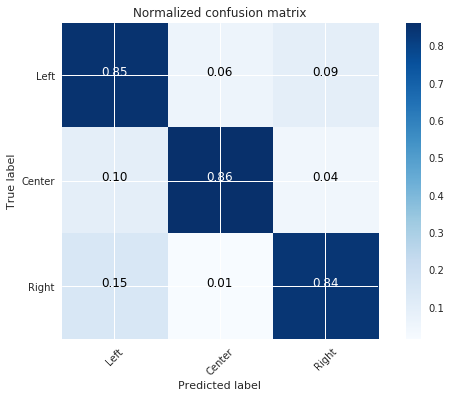

In [86]:
import matplotlib.pyplot as plt
import itertools

class_names = ['Left','Center','Right']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()